Comparing the DG method with the Trefftz-DG method on the anisotropic mesh in 1+1 dimensions. 

In [1]:
N = 2
c=2
t_steps = c*N
order = 12
k = 1
D = 2

In [2]:
import sys
sys.path.append("..")
from ngsolve import *
SetHeapSize(100*1000*1000)

from trefftzngs import *
from DGeq import *
from prodmesh import *

In [3]:
truesol =  sin( k*(c*y + x) )#exp(-pow(c*x+y,2)))#
v0 = c*k*cos(k*(c*y+x))#grad(U0)[0]
sig0 = -k*cos(k*(c*y+x))#-grad(U0)[1]

In [4]:
def MakeL2System(v0,sig0,fes,alpha=0,beta=0,gamma=1):
    sig,v = fes.TrialFunction()
    tau,w = fes.TestFunction()

    vo = v.Other()
    sigo = sig.Other()
    wo = w.Other()
    tauo = tau.Other()

    h = specialcf.mesh_size
    n = specialcf.normal(2)
    n_t = n[1]/Norm(n)
    n_x = n[0]/Norm(n)

    mean_v = 0.5*(v+vo)
    mean_w = 0.5*(w+wo)
    mean_sig = 0.5*(sig+sigo)
    mean_tau = 0.5*(tau+tauo)

    jump_vx = ( v - vo ) * n_x
    jump_wx = ( w - wo ) * n_x
    jump_sigx = ( sig - sigo ) * n_x
    jump_taux = ( tau - tauo ) * n_x

    jump_vt = ( v - vo ) * n_t
    jump_wt = ( w - wo ) * n_t
    jump_sigt = ( sig - sigo ) * n_t
    jump_taut = ( tau - tauo ) * n_t

    timelike = n_x**2 #IfPos(n_t,0,IfPos(-n_t,0,1)) # n_t=0
    spacelike = n_t**2 #IfPos(n_x,0,IfPos(-n_x,0,1)) # n_x=0

    a = BilinearForm(fes)
    a += SymbolicBFI(  -v*(grad(tau)[0]+pow(c,-2)*grad(w)[1]) - sig*(grad(tau)[1]+grad(w)[0])  )
    a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt) + IfPos(n_t,sig,sigo)*(jump_taut) ) ,VOL,  skeleton=True ) #space like faces, no jump in x since horizontal
    a += SymbolicBFI( timelike 	* ( mean_v*jump_taux + mean_sig*jump_wx + alpha*jump_vx*jump_wx + beta*jump_sigx*jump_taux ) ,VOL, skeleton=True ) #time like faces
    a += SymbolicBFI( spacelike * IfPos(n_t,1,0) * ( pow(c,-2)*v*w + sig*tau ), BND, skeleton=True) #t=T (or *x)
    a += SymbolicBFI( timelike 	* ( sig*n_x*w + alpha*v*w ), BND, skeleton=True) #dirichlet boundary 'timelike'
    a.Assemble()

    f = LinearForm(fes)
    f += SymbolicLFI( spacelike * IfPos(-n_t,1,0) *  ( pow(c,-2)*v0*w + sig0*tau ), BND, skeleton=True) #t=0 (or *(1-x))
    f += SymbolicLFI( timelike 	* ( v0 * (alpha*w - tau*n_x) ), BND, skeleton=True) #dirichlet boundary 'timelike'
    f.Assemble()

    return [a,f]

In [5]:
def WaveTrefftz(order,btype,c,truesol,v0,sig0):
    fes = FESpace("trefftzfespace", mesh, order = order, wavespeed = c, dgjumps=True, basistype = btype)
    [a,f] = DGeqsys(fes,truesol,v0,sig0,c,v0)
    [gfu, cond] = DGsolve(fes,a,f)
    
    dof = fes.ndof/(N*t_steps)#scipy.special.binom(D-1 + ordr, ordr) + scipy.special.binom(D-1 + ordr-1, ordr-1)

    gradtruesol = CoefficientFunction((-sig0,v0))
    sH1error = sqrt(Integrate((gradtruesol - grad(gfu))*(gradtruesol - grad(gfu)), mesh))
    return [dof,cond,0,sH1error]

def WaveL2(order,truesol,v0,sig0):
    X = L2(mesh, order=order)
    fes = FESpace([X,X], flags = { "dgjumps" : True })
    [a,f] = MakeL2System(v0,sig0,fes)
    [gfu, cond] = DGsolve(fes,a,f)
    
    dof=fes.ndof/(N*t_steps)#X.ndof/(N*t_steps)
    
    err0=sig0 - gfu.components[0]
    err1=v0 - gfu.components[1]
    sH1error = sqrt(Integrate( err0*err0 + err1*err1, mesh))
    return [dof,cond,0,sH1error]
    

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def errfig(sol,xaxis,yaxis,xlabel,saveas):
    fig = plt.figure()
    ax = fig.gca()
    plt.semilogy(sol[sol[:,0]==0,xaxis], sol[sol[:,0]==0,yaxis], '-o', label="L2 a,b=0")
    plt.semilogy(sol[sol[:,0]==1,xaxis], sol[sol[:,0]==1,yaxis], '--x', label="Trefftz a,b=0")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Wavespeed: ' + str(c) + " Meshsize: " + str(1/N))
    plt.legend()
    plt.ylabel(data[i])
    plt.xlabel(xlabel)
    #plt.savefig(saveas)
    plt.show()

In [7]:
import scipy.special
solution = []

mesh = CartSquare(N,t_steps)

for ordr in range(2,order):
    print("run order: " + str(ordr))

    btype = 0
    [dof,cond,L2error,sH1error] = WaveL2(ordr,truesol,v0,sig0)
    solution.append([btype, ordr, dof, cond, L2error, sH1error])
    print("btype: " + 'L2' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

    btype = 1
    [dof,cond,L2error,sH1error] = WaveTrefftz(ordr+1,0,c,truesol,v0,sig0)
    solution.append([btype, ordr, dof, cond, L2error, sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

run order: 2
btype: L2 dof: 18.0 cond: 45.0595826783 L2error: 0 H1error: 0.0020625184107005124
btype: Trefftz dof: 7.0 cond: 30.5479974228 L2error: 0 H1error: 0.004069213513349027
run order: 3
btype: L2 dof: 32.0 cond: 111.572693424 L2error: 0 H1error: 3.052588221161367e-05
btype: Trefftz dof: 9.0 cond: 89.0295860955 L2error: 0 H1error: 0.0001881794035338172
run order: 4
btype: L2 dof: 50.0 cond: 222.677119374 L2error: 0 H1error: 2.6482384737098636e-06
btype: Trefftz dof: 11.0 cond: 315.028718804 L2error: 0 H1error: 1.8290379040592942e-05
run order: 5
btype: L2 dof: 72.0 cond: 389.434480791 L2error: 0 H1error: 2.403968091837015e-07
btype: Trefftz dof: 13.0 cond: 1812.01706667 L2error: 0 H1error: 5.81914121128986e-07
run order: 6
btype: L2 dof: 98.0 cond: 626.812385231 L2error: 0 H1error: 1.5211242257989697e-09
btype: Trefftz dof: 15.0 cond: 7917.03521798 L2error: 0 H1error: 2.1584743104272775e-08
run order: 7
btype: L2 dof: 128.0 cond: 950.849869393 L2error: 0 H1error: 3.50959481439541

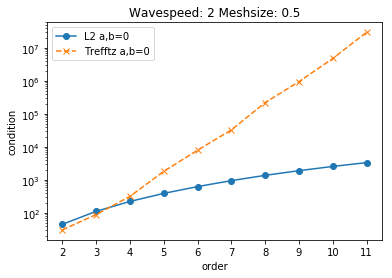

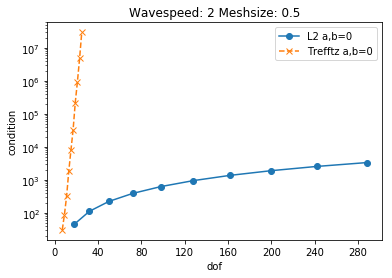

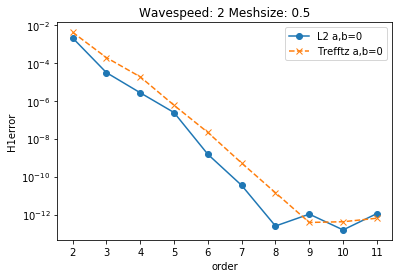

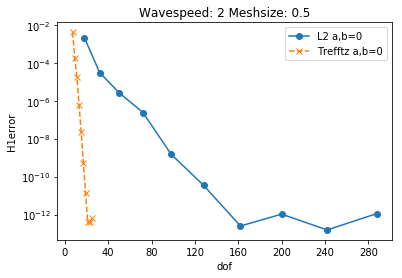

In [8]:
data = ['condition', 'L2error', 'H1error']
sol = np.array(solution)

for i in [0,2]:
    errfig(sol,1,i+3,'order',"results/pvt_"+data[i]+".png")
    errfig(sol,2,i+3,'dof',"results/pvtdof_"+data[i]+".png")